In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import itertools as itt
import pyfolio as pf
import math
from IPython.display import Image
import quantstats as qs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import sklearn.base as skBase


# import local packages
from qfml_workflow import dataStructures
from qfml_workflow import cusumFilter
from qfml_workflow import labeling
from qfml_workflow import multiprocess
from qfml_workflow import sampleWeights
from qfml_workflow import fractionalDifferencing
from qfml_workflow import betSizing
from qfml_workflow import crossValidation
from qfml_workflow import featureImportance
from qfml_workflow import backtesting
#from qfml_workflow import model
from qfml_workflow import hyperparamTuning
from qfml_workflow import performanceReporting
from qfml_workflow.model import SimpleModel
from qfml_workflow import mlModels

In [70]:
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import talib as ta

In [71]:
#dbarsDatapath = 'E:\Prado Research\qfml_workflow\data\SPY_dbars_thesis_dynamic_no_lookahead_redownload_correct.csv'
dbarsDatapath = 'E:\Prado Research\qfml_workflow\data\SPY_dbars_thesis_dynamic_nolookahead_dollar_market_redownload_correct.csv'
#dbarsDatapath = 'E:/Prado Research/qfml_workflow/data/IWM_dbars_thesis_dynamic_nolookahead_dollar_market_redownload_correct.csv'
dollarBars = pd.read_csv(dbarsDatapath)
dollarBars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28389 entries, 0 to 28388
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          28389 non-null  int64  
 1   open               28389 non-null  float64
 2   high               28389 non-null  float64
 3   low                28389 non-null  float64
 4   close              28389 non-null  float64
 5   volume             28389 non-null  float64
 6   tick_num           28389 non-null  int64  
 7   num_ticks_sampled  28389 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 1.7 MB


### Remove dbars outside of market hours

In [72]:
reindexdfCopy = dollarBars.copy()

In [73]:
reindexdfCopy['timestamp'] = pd.to_datetime(reindexdfCopy['timestamp'], unit='ns', utc=True)
reindexdfCopy = reindexdfCopy.reset_index()
reindexdfCopy = reindexdfCopy.set_index('timestamp', drop=True)
reindexTime = reindexdfCopy.index.tz_convert(
    "America/New_York"
)
tsIndex = pd.DatetimeIndex(reindexTime)
reindexdfCopy = reindexdfCopy.iloc[tsIndex.indexer_between_time('9:30','16:00')]
reindexdfCopy
dollarBars = dollarBars.iloc[reindexdfCopy['index']]
dollarBars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22648 entries, 0 to 28388
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          22648 non-null  int64  
 1   open               22648 non-null  float64
 2   high               22648 non-null  float64
 3   low                22648 non-null  float64
 4   close              22648 non-null  float64
 5   volume             22648 non-null  float64
 6   tick_num           22648 non-null  int64  
 7   num_ticks_sampled  22648 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 1.6 MB


In [74]:
del reindexdfCopy

### fix tick duplicates

In [75]:
dollarBars['timestamp'] = pd.to_datetime(dollarBars['timestamp'],unit='ns')
dollarBars.set_index('timestamp', drop=True, inplace=True)
print(dollarBars.index.duplicated(keep='first').sum())

0


### Create model for side

In [76]:
# make primary model
fast_window = 20
slow_window = 50

dollarBars['fast_mavg'] = dollarBars['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
dollarBars['slow_mavg'] = dollarBars['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

# Compute sides
dollarBars['side'] = np.nan

long_signals = dollarBars['fast_mavg'] >= dollarBars['slow_mavg'] 
short_signals = dollarBars['fast_mavg'] < dollarBars['slow_mavg'] 
dollarBars.loc[long_signals, 'side'] = 1
dollarBars.loc[short_signals, 'side'] = -1

# lag the signal to remove look-ahead bias
dollarBars['side'] = dollarBars['side'].shift(1)

In [77]:
dollarBars['side'].value_counts()

 1.0    13356
-1.0     9242
Name: side, dtype: int64

# train and test indicies

In [78]:
trainingIndicies = math.floor((len(dollarBars) -1) * 0.7)
testingIndicies = math.floor((len(dollarBars) -1) * 0.3)

trainingSet = dollarBars.head(trainingIndicies)
testingSet = dollarBars.tail(testingIndicies)
print(f"Training set length: {len(trainingSet)}, Validation set length: {len(testingSet)}")

Training set length: 15852, Validation set length: 6794


In [79]:
dollarBars.dropna(axis=0, how='any', inplace=True)

# Set up tb labels and CUSUM

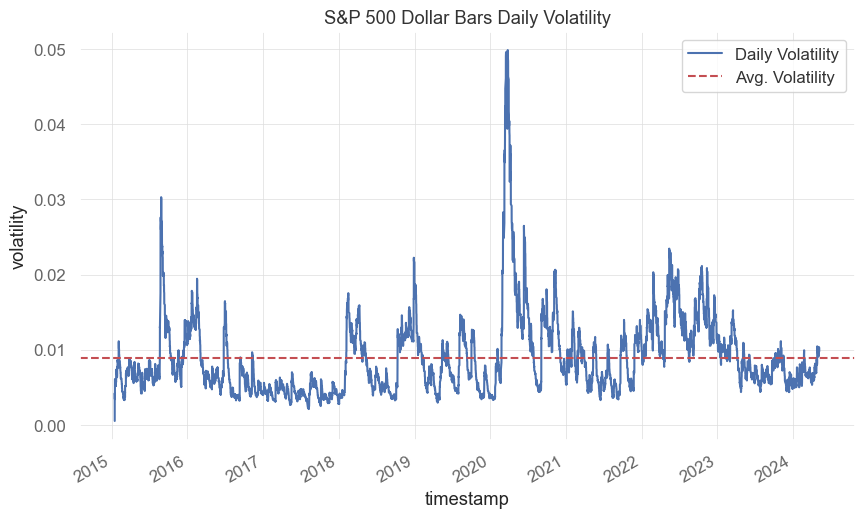

In [80]:
# hyperparam here
dailyVol = cusumFilter.getDailyVol(dollarBars['close'], span0=100)

f,ax=plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(),ls='--',color='r', label='Avg. Volatility')
ax.set_title('S&P 500 Dollar Bars Daily Volatility')
ax.set_ylabel('volatility')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels= ['Daily Volatility', 'Avg. Volatility'])

In [81]:
cusumEvents = cusumFilter.getTEvents(dollarBars['close'],h=dailyVol.loc[:trainingSet.index[-1]].dropna().mean())

100%|██████████| 22596/22596 [00:00<00:00, 23056.18it/s]


In [82]:
vertical_barriers = labeling.addVerticalBarrier(cusumEvents, dollarBars['close'], numDays=1)

In [83]:
# multiply horizontal profit taking barrier by 1 and stop loss barrier by 2
pt_sl = [1, 2]

# minimum return
min_ret = 0.005


dailyVol = dailyVol.reindex(cusumEvents)


allTripleBarrierEvents = labeling.getEvents(close=dollarBars['close'],
                                               tEvents=cusumEvents,
                                               ptSl=pt_sl,
                                               trgt=dailyVol,
                                               minRet=min_ret,
                                               numThreads=3,
                                               t1=vertical_barriers, # vertical barrier times
                                               side=dollarBars['side']) # side prediction

allLabels = labeling.getBins(allTripleBarrierEvents, dollarBars['close'])

2024-05-13 00:50:34.449559 100.0% applyPtSlOnT1 done after 0.04 minutes. Remaining 0.0 minutes..


### Create features

In [84]:
#fractionalDifferencing.getFeatureADF(dollarBars[['open', 'high', 'low', 'close']])
#ffdPrices = dollarBars[['open', 'high', 'low', 'close', 'volume']].copy()
#dollarBars[['ffdOpen', 'ffdHigh', 'ffdLow', 'ffdClose']] = fractionalDifferencing.getMinFFD_feature_wise(dollarBars[['open', 'high', 'low', 'close']])#.cumsum())
#dollarBars = dollarBars.apply(pd.to_numeric)
#dollarBars[['ffdOpen', 'ffdHigh', 'ffdLow', 'ffdClose']].info()

In [85]:
#dollarBars[['ffdOpen', 'ffdHigh', 'ffdLow', 'ffdClose']] = dollarBars[['open', 'high', 'low', 'close']]

In [86]:
dollarBars, featureList, nonFeatures = mlModels.paperFeaturesTrendLayerMultiParam(dollarBars,paramDict=[5,10,25,50,]) #100])
#dollarBars, featureList, nonFeatures = mlModels.createFeatures(dollarBars)
paramDict = [5,10,25,50,]

#dollarBars, featureList, categoricalFeats, continuousFeats, nonFeatures = mlModels.allFeaturesTrendLayer(dollarBars, paramDict)
categoricalFeats = [x for x in featureList if x != 'ffdClose' and x != 'volume']
#categoricalFeats = []
#continuousFeats = [x for x in featureList if x not in categoricalFeats]

featureList = categoricalFeats
continuousFeats = []

In [87]:
#dollarBars, featureList, nonFeatures  = mlModels.createFeaturesHT(dollarBars)
#categoricalFeats = []
#continuousFeats = featureList

#dollarBars, featureList, categoricalFeats, continuousFeats, nonFeatures = mlModels.createComboFeatures(dollarBars)

In [88]:
#dollarBars = dollarBars.drop(['ffdOpen', 'ffdHigh', 'ffdLow', 'ffdClose'], axis=1)

In [89]:
dollarBars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22598 entries, 2015-01-14 18:22:21.150000 to 2024-05-06 16:45:12.566412032
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               22598 non-null  float64
 1   high               22598 non-null  float64
 2   low                22598 non-null  float64
 3   close              22598 non-null  float64
 4   volume             22597 non-null  float64
 5   tick_num           22598 non-null  int64  
 6   num_ticks_sampled  22598 non-null  int64  
 7   fast_mavg          22598 non-null  float64
 8   slow_mavg          22598 non-null  float64
 9   side               22598 non-null  float64
 10  sma_5_trend        22597 non-null  float64
 11  wma_5_trend        22597 non-null  float64
 12  mom_5_trend        22597 non-null  float64
 13  willR_5_trend      22597 non-null  float64
 14  macd_5_trend       22597 non-null  float64
 15  stoch_k_5_trend   

In [90]:
dollarBars = dollarBars.dropna()
dollarBars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22597 entries, 2015-01-14 19:34:09.350000 to 2024-05-06 16:45:12.566412032
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               22597 non-null  float64
 1   high               22597 non-null  float64
 2   low                22597 non-null  float64
 3   close              22597 non-null  float64
 4   volume             22597 non-null  float64
 5   tick_num           22597 non-null  int64  
 6   num_ticks_sampled  22597 non-null  int64  
 7   fast_mavg          22597 non-null  float64
 8   slow_mavg          22597 non-null  float64
 9   side               22597 non-null  float64
 10  sma_5_trend        22597 non-null  float64
 11  wma_5_trend        22597 non-null  float64
 12  mom_5_trend        22597 non-null  float64
 13  willR_5_trend      22597 non-null  float64
 14  macd_5_trend       22597 non-null  float64
 15  stoch_k_5_trend   

### Create train and validation sets

In [91]:
trainingSetEvents = allTripleBarrierEvents.loc[:trainingSet.index[-1]]
trainingSetLabels = allLabels.loc[:trainingSet.index[-1]]
testingSetEvents = allTripleBarrierEvents.loc[testingSet.index[0]:]
testingSetLabels = allLabels.loc[testingSet.index[0]:]

X_train = dollarBars[featureList].reindex(trainingSetLabels.index).dropna()
y_train = trainingSetLabels['bin'].reindex(X_train.index)
X_test = dollarBars[featureList].reindex(testingSetLabels.index).dropna()
y_test = testingSetLabels['bin'].reindex(X_test.index)

prices_train = dollarBars.loc[X_train.index][nonFeatures]

# Apply FracDiff

In [92]:
X_train_features = X_train[continuousFeats]
X_test_features = X_test[continuousFeats]
fractionalDifferencing.getFeatureADF(X_train_features)

,adfStat,pVal,lags,nObs,95% conf


In [93]:
nstFeats = fractionalDifferencing.getNonStationaryFeats(X_train_features)

if nstFeats != []:
    dvalRangeCurrentFeats =  np.linspace(0,2,22)
    X_train[nstFeats], dStarDict = fractionalDifferencing.getMinFFD_feature_wise_dStar(X_train_features[nstFeats])
    X_test[nstFeats] = fractionalDifferencing.fracDiffFFD_dStar(X_test_features[nstFeats],dStarDict) 

In [94]:
X_train = X_train.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)
X_train = X_train.dropna()
X_test = X_test.dropna()

trainingSetEvents = trainingSetEvents.loc[X_train.index]
trainingSetLabels = trainingSetLabels.loc[X_train.index]
testingSetLabels = testingSetLabels.loc[X_test.index]
testingSetEvents = testingSetEvents.loc[X_test.index]

y_train = trainingSetLabels['bin'].reindex(X_train.index)
y_test = testingSetLabels['bin'].reindex(X_test.index)

# Sample Weights

0.5 0.0006269160319903148


Text(0, 0.5, 'Weight')

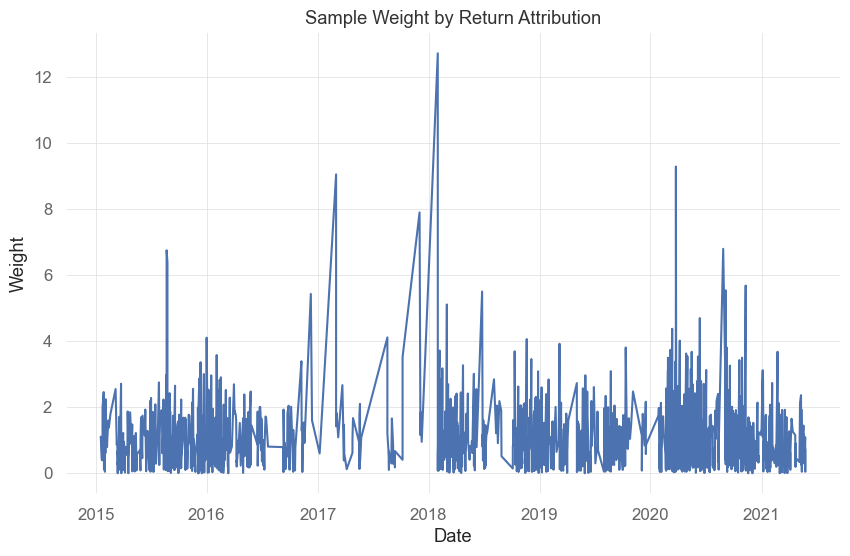

In [95]:
#weights = sampleWeights.getWeights(prices_train[['close']], trainingSetEvents)
weights = sampleWeights.getWeights(dollarBars.loc[X_train.index][['close']], trainingSetEvents)
returnBasedWeights = weights['w']

timeBasedWeightsLinearDecay = sampleWeights.getTimeDecay(weights['tW'], clfLastW=0.5)
plt.plot(returnBasedWeights)
plt.title('Sample Weight by Return Attribution')
plt.xlabel("Date")
plt.ylabel("Weight")

In [96]:
indicatorMatrix = sampleWeights.getIndMatrix(X_train.index, trainingSetEvents['t1'])
avgUniqueness = sampleWeights.getAvgUniqueness(indicatorMatrix)
# reindex avgUniqueness to make a bettset_indexer plot
avgUByDate = pd.Series(avgUniqueness.values, index=y_train.index)

In [97]:
timeWeightedRetW = returnBasedWeights * timeBasedWeightsLinearDecay

# Select Model

### PCA model select

RF_pipe_PCA: 0.497070 (0.041614)
None
ADA_pipe_PCA: 0.517789 (0.029442)
None
SVC_pipe_PCA: 0.514659 (0.023341)
None
XGB_pipe_PCA: 0.499001 (0.010286)
None
bgRF_pipe_PCA: 0.520965 (0.036071)
None
bgDT_pipe_PCA: 0.497070 (0.041614)
None


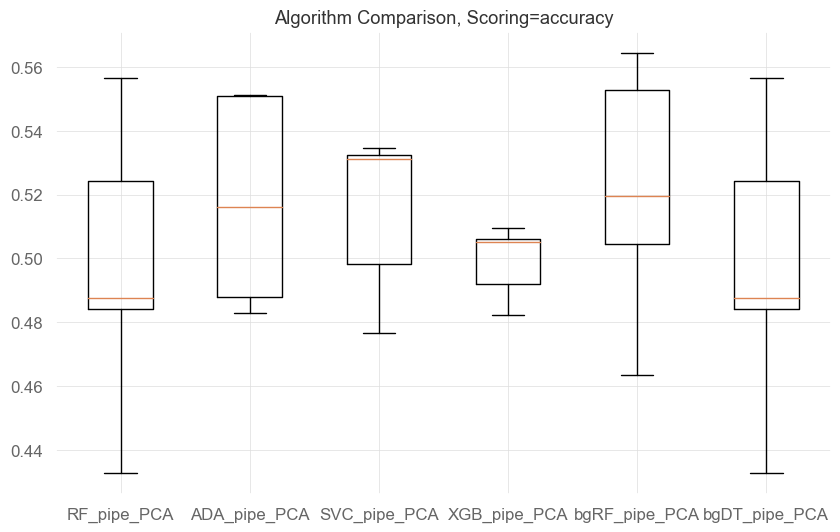

In [98]:
cvSplits = 5
pctEmb = 0.01
modelRepository = mlModels.ModelsML(continuousFeats=continuousFeats, categoricalFeats=categoricalFeats)
cvGen = crossValidation.PurgedKFold(n_splits=cvSplits, t1=trainingSetEvents['t1'], pctEmbargo=pctEmb)
mlModels.selectModelPipeline(modelRepository.pipelinesPCA, X_train, y_train, trainingSetEvents,
                             sampleWeight=timeWeightedRetW, avgUMean=avgUniqueness.mean(),  
                             numFolds=cvSplits,cvGen=cvGen, pctEmbargo=pctEmb, scoringMethod='accuracy'
                             )

RF_pipe_PCA: -0.699735 (0.008098)
None
ADA_pipe_PCA: -0.693120 (0.000043)
None
SVC_pipe_PCA: -0.696023 (0.007008)
None
XGB_pipe_PCA: -0.701151 (0.005453)
None
bgRF_pipe_PCA: -0.709154 (0.007217)
None
bgDT_pipe_PCA: -0.699686 (0.008936)
None


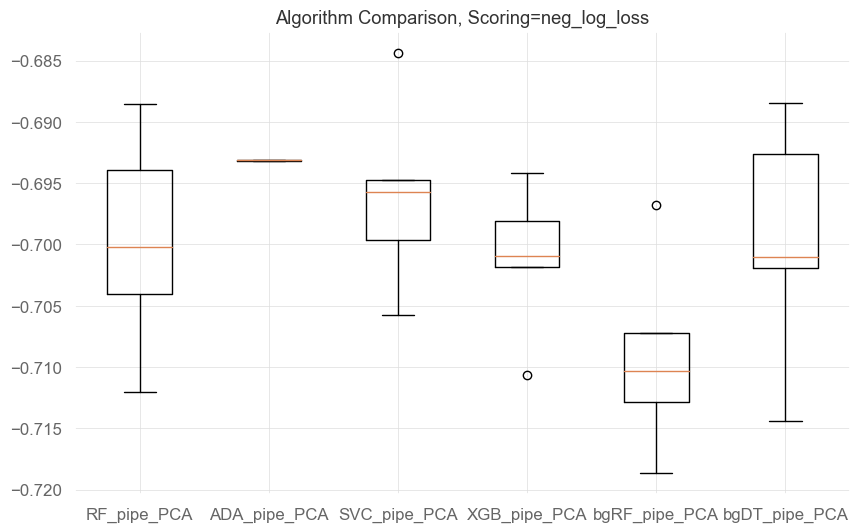

In [99]:
cvSplits = 5
pctEmb = 0.01
modelRepository = mlModels.ModelsML(continuousFeats=continuousFeats, categoricalFeats=categoricalFeats)
cvGen = crossValidation.PurgedKFold(n_splits=cvSplits, t1=trainingSetEvents['t1'], pctEmbargo=pctEmb)
mlModels.selectModelPipeline(modelRepository.pipelinesPCA, X_train, y_train, trainingSetEvents,
                             sampleWeight=timeWeightedRetW, avgUMean=avgUniqueness.mean(),  
                             numFolds=cvSplits,cvGen=cvGen, pctEmbargo=pctEmb, scoringMethod='neg_log_loss'
                             )

### Standard model select

RF_pipe_standard: 0.497070 (0.041614)
None
ADA_pipe_standard: 0.517789 (0.029442)
None
SVC_pipe_standard: 0.514659 (0.023341)
None
XGB_pipe_standard: 0.499001 (0.010286)
None
bgRF_pipe_standard: 0.520965 (0.036071)
None
bgDT_pipe_standard: 0.497070 (0.041614)
None


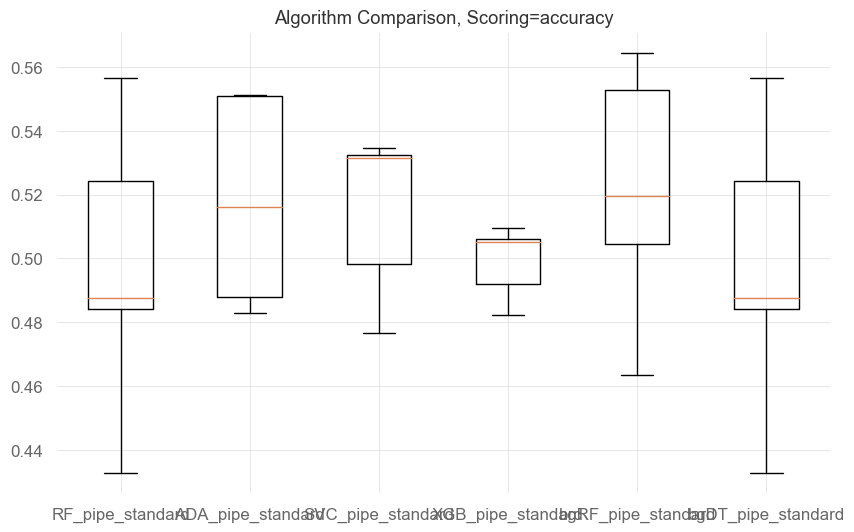

In [100]:
cvSplits = 5
pctEmb = 0.01
modelRepository = mlModels.ModelsML(continuousFeats=continuousFeats, categoricalFeats=categoricalFeats)
cvGen = crossValidation.PurgedKFold(n_splits=cvSplits, t1=trainingSetEvents['t1'], pctEmbargo=pctEmb)
mlModels.selectModelPipeline(modelRepository.pipelinesStandard, X_train, y_train, trainingSetEvents,
                             sampleWeight=timeWeightedRetW, avgUMean=avgUniqueness.mean(),  
                             numFolds=cvSplits,cvGen=cvGen, pctEmbargo=pctEmb, scoringMethod='accuracy'
                             )

RF_pipe_standard: -0.699735 (0.008098)
None
ADA_pipe_standard: -0.693120 (0.000043)
None
SVC_pipe_standard: -0.696023 (0.007008)
None
XGB_pipe_standard: -0.701151 (0.005453)
None
bgRF_pipe_standard: -0.709154 (0.007217)
None
bgDT_pipe_standard: -0.699686 (0.008936)
None


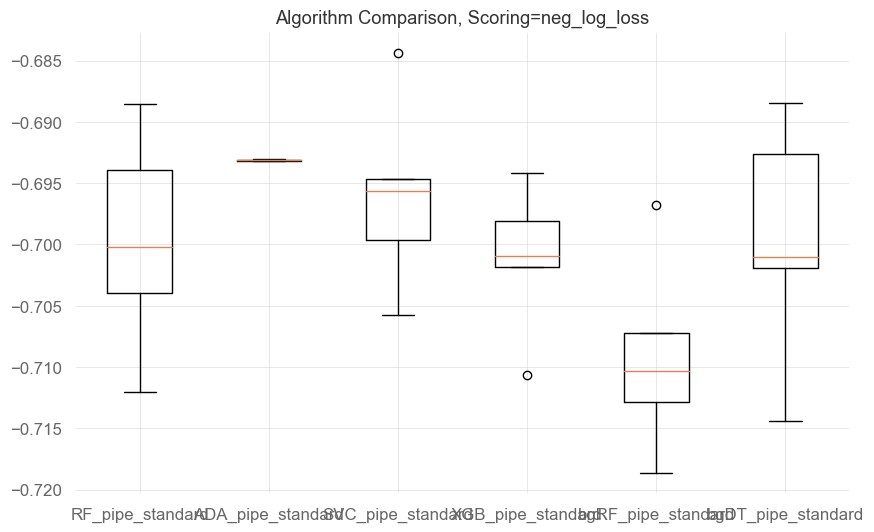

In [101]:
cvSplits = 5
pctEmb = 0.01
modelRepository = mlModels.ModelsML(continuousFeats=continuousFeats, categoricalFeats=categoricalFeats)
cvGen = crossValidation.PurgedKFold(n_splits=cvSplits, t1=trainingSetEvents['t1'], pctEmbargo=pctEmb)
mlModels.selectModelPipeline(modelRepository.pipelinesStandard, X_train, y_train, trainingSetEvents,
                             sampleWeight=timeWeightedRetW, avgUMean=avgUniqueness.mean(),  
                             numFolds=cvSplits,cvGen=cvGen, pctEmbargo=pctEmb, scoringMethod='neg_log_loss'
                             )

# select model

In [102]:
svcModel = modelRepository.pipelinesPCA[2][2]
rfBootModel = modelRepository.pipelinesPCA[4][2]
rfBootStandard = modelRepository.pipelinesStandard[4][2]
svcModelStandard = modelRepository.pipelinesStandard[4][2]
rfModelName = modelRepository.pipelinesPCA[4][1]
svcModelName = modelRepository.pipelinesPCA[2][1]

In [147]:
categoricalFeats

['sma_5_trend',
 'wma_5_trend',
 'mom_5_trend',
 'willR_5_trend',
 'macd_5_trend',
 'stoch_k_5_trend',
 'stoch_d_5_trend',
 'rsi_5_trend',
 'ad_osc_5_trend',
 'sma_10_trend',
 'wma_10_trend',
 'mom_10_trend',
 'willR_10_trend',
 'macd_10_trend',
 'stoch_k_10_trend',
 'stoch_d_10_trend',
 'rsi_10_trend',
 'ad_osc_10_trend',
 'sma_25_trend',
 'wma_25_trend',
 'mom_25_trend',
 'macd_25_trend',
 'stoch_k_25_trend',
 'stoch_d_25_trend',
 'CCI_25_trend',
 'sma_50_trend',
 'wma_50_trend',
 'mom_50_trend',
 'willR_50_trend',
 'macd_50_trend',
 'stoch_k_50_trend',
 'stoch_d_50_trend',
 'ad_osc_50_trend']

In [146]:
#dropList = [ 'willR_25_trend', 
 #           'rsi_50_trend', 'rsi_25_trend', 'ad_osc_25_trend', 'CCI_10_trend']
 #'CCI_50_trend',
#for x in dropList:
 #   featureList.remove(x)
    #categoricalFeats.remove(x)

#X_train = X_train[featureList]
#X_test = X_test[featureList]

##### train models

In [148]:
rfBootModel.fit(X_train, y_train)

ValueError: A given column is not a column of the dataframe

In [104]:
svcModel.fit(X_train, y_train)

Pipeline(steps=[('scaleCT',
                 ColumnTransformer(transformers=[('pcaPipe',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=0.95))]),
                                                  []),
                                                 ('pass', 'passthrough',
                                                  ['sma_5_trend', 'wma_5_trend',
                                                   'mom_5_trend',
                                                   'willR_5_trend',
                                                   'macd_5_trend',
                                                   'stoch_k_5_trend',
                                                   'stoch_d_5_trend',
                              

# training set statistics

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       802
         1.0       0.99      0.99      0.99       950

    accuracy                           0.99      1752
   macro avg       0.99      0.99      0.99      1752
weighted avg       0.99      0.99      0.99      1752

Confusion Matrix
[[797   5]
 [ 14 936]]

Accuracy
0.9891552511415526


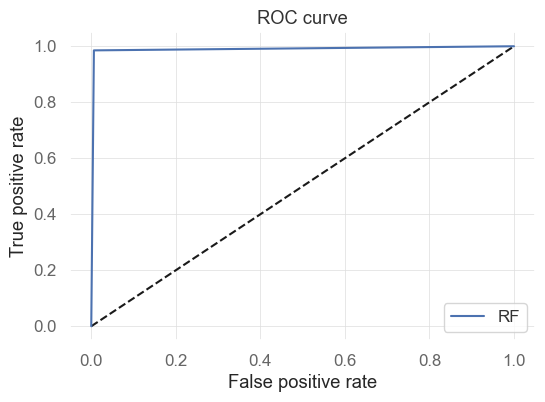

In [105]:

rfPreds = rfBootModel.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(trainingSetLabels['bin'], rfPreds)
print(classification_report(trainingSetLabels['bin'], rfPreds))

print("Confusion Matrix")
print(confusion_matrix(trainingSetLabels['bin'], rfPreds))

print('')
print("Accuracy")
print(accuracy_score(trainingSetLabels['bin'], rfPreds))

plt.figure(1, figsize=(6,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# feature importance

In [106]:
def plotFeatImportance(pathOut,imp,oob,oos,method,tag=0,simNum=0,**kargs):
    # plot mean imp bars with std
    plt.figure(figsize=(10,imp.shape[0]/5.))
    imp=imp.sort_values('mean',ascending=True)
    ax=imp['mean'].plot(kind='barh',color='b',alpha=.25,xerr=imp['std'],
                        error_kw={'ecolor':'r'}, label='Feature')
    if method=='MDI':
        plt.xlim([0,imp.sum(axis=1).max()])
        plt.axvline(1./imp.shape[0],linewidth=1,color='r',linestyle='dotted')
    ax.get_yaxis().set_visible(False)
    for i,j in zip(ax.patches,imp.index):ax.text(i.get_width()/2,
            i.get_y()+i.get_height()/2,j,ha='center',va='center',
            color='black')
    #plt.title(str(method)+': tag='+str(tag)+' | simNum='+str(simNum)+' | oob='+str(round(oob,4))+
    #            ' | oos='+str(round(oos,4)))

    if method == 'SFI':
        plt.title("Single Feature Importance for Meta-Label Model")
        plt.xlabel("Single Feature Importance")
    elif method == "MDI":
        plt.title("Mean Decrease Impurity for Meta-Label Model")
        plt.xlabel("Mean Decrease Impurity")
    elif method == "MDA":
        plt.title("Mean Decrease Accuracy for Meta-Label Model")
        plt.xlabel("Mean Decrease Accuracy")
    #plt.title("Mean Decrease Accuracy for Meta-Label Model")
    #plt.xlabel("Mean Decrease Accuracy")
    #plt.savefig(pathOut+'featImportance_'+str(method)+str(simNum)+'.png',dpi=100)
    #plt.clf();#plt.close()
    plt.show()
    return

In [107]:
trainingEventLabelUnion = pd.DataFrame()
trainingEventLabelUnion['t1'] = trainingSetEvents['t1']
trainingEventLabelUnion['bin'] = trainingSetLabels['bin']
trainingEventLabelUnion['w'] = timeWeightedRetW

In [108]:
numCVSplits=5
sfiCVGen = crossValidation.PurgedKFold(n_splits=numCVSplits, t1=trainingEventLabelUnion['t1'], pctEmbargo=0.01)

#featureImportance.featImpMDIGeneric(modelPipeline[modelName], modelFeats, estimators=modelPipeline[modelName].)
mdIFeatImportanceRF = featureImportance.featImpMDI(rfBootStandard[rfModelName], featureList)
mdaFeatImportanceRF, osScoreRF = featureImportance.featImpMDACustomPipe(rfBootStandard, X_train, y_train, numCVSplits, trainingEventLabelUnion['w'],rfModelName+'__sample_weight', trainingEventLabelUnion['t1'], pctEmbargo=0.01)
#sfiFeatImportanceRF = featureImportance.auxFeatImpSFICustomPipe(featureList, rfBootStandard, X_train, trainingEventLabelUnion, rfModelName+'__sample_weight', scoring='accuracy',cvGen=sfiCVGen)

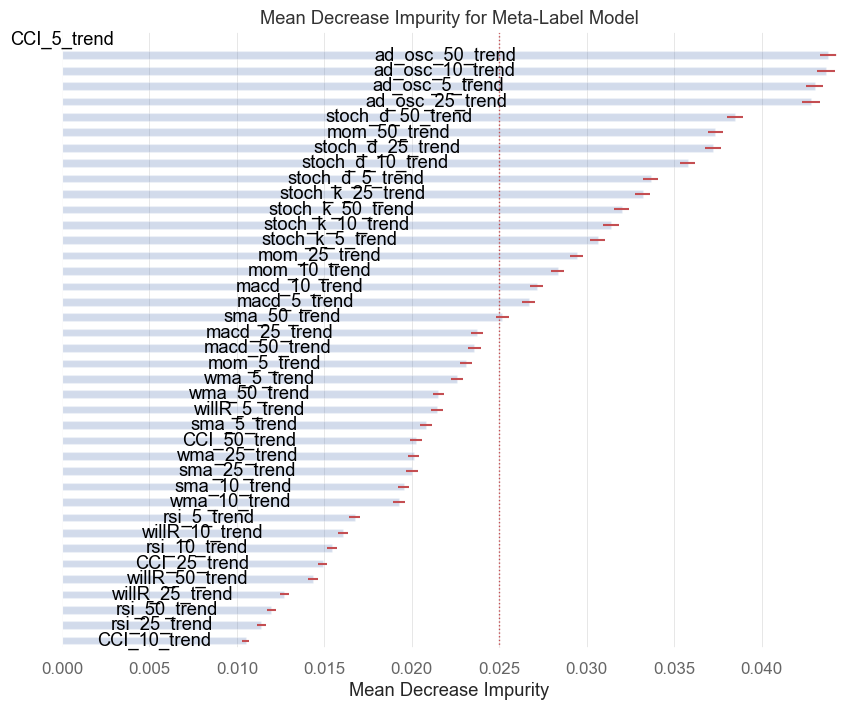

In [109]:
plotFeatImportance('',mdIFeatImportanceRF,None,None,method='MDI',)

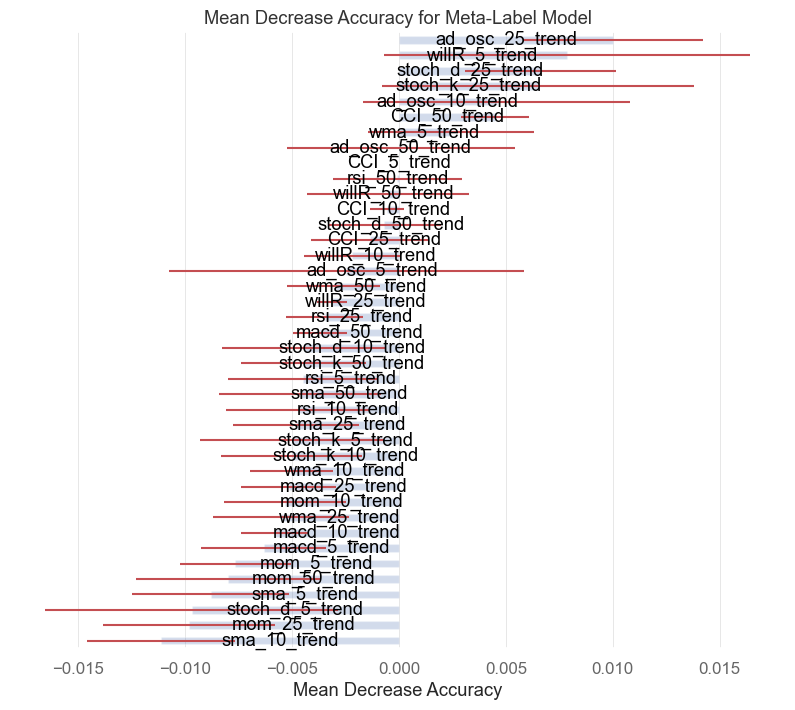

In [110]:
plotFeatImportance('',mdaFeatImportanceRF,osScoreRF,None,method='MDA',)

In [111]:
numCVSplits=5
sfiCVGen = crossValidation.PurgedKFold(n_splits=numCVSplits, t1=trainingEventLabelUnion['t1'], pctEmbargo=0.01)
svcModelStandard.fit(X_train, y_train)
#featureImportance.featImpMDIGeneric(modelPipeline[modelName], modelFeats, estimators=modelPipeline[modelName].)
#mdIFeatImportanceSVC = featureImportance.featImpMDI(svcModel[svcModelName], featureList)
mdaFeatImportanceSVC, osScoreSVC = featureImportance.featImpMDACustomPipe(svcModel, X_train, y_train, numCVSplits, trainingEventLabelUnion['w'],svcModelName+'__sample_weight', trainingEventLabelUnion['t1'], pctEmbargo=0.01)
#sfiFeatImportanceSVC = featureImportance.auxFeatImpSFICustomPipe(featureList, svcModel, X_train, trainingEventLabelUnion, svcModelName+'__sample_weight', scoring='accuracy',cvGen=sfiCVGen)

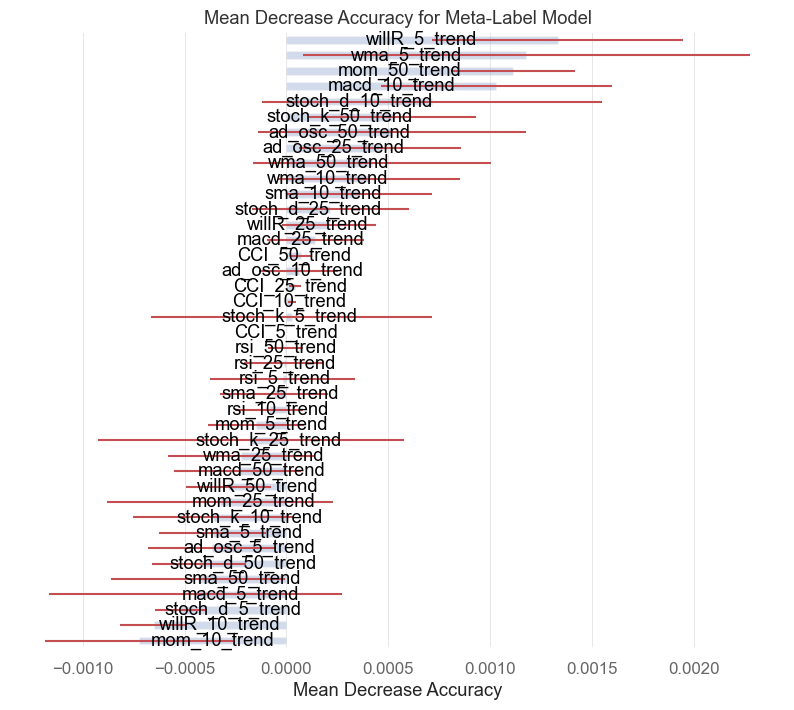

In [112]:
plotFeatImportance('',mdaFeatImportanceSVC,osScoreSVC,None,method='MDA')

In [113]:
#plotFeatImportance('',sfiFeatImportanceSVC,None,None,method='SFI')

# hyper-param tune

In [114]:
rfParams = {
            rfModelName+'__n_estimators': [20, 50, 100, 200, 300, 500, 800, 1000, 1500],
            rfModelName+'__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.90, 0.92, 0.95, 1.0],
            rfModelName+'__random_state':[12],    
}
svcParams = {
            svcModelName+'__kernel':['linear', 'rbf', 'poly'],
            #svcModelName+'__gamma':[0.1, 1, 5, 10, 50, 100],
            #svcModelName+'__C':[0.1, 1, 10, 50, 100, 250, 500, 1000]
            svcModelName+'__gamma':[0.1, 1, 5, 10, 50,],
            svcModelName+'__C':[0.1, 1, 10, 50, 100, 250, ]
}

In [115]:
# Bagging parameters
baggingParams = [10, 0, 1]
pipelineRF = hyperparamTuning.clfHyperFit(X_train, y_train, trainingSetEvents['t1'], 
                                          rfBootModel, rfParams,bagging=baggingParams, pctEmbargo=0.01,
                                          bgRF__sample_weight=timeWeightedRetW)
paramDict = pipelineRF.get_params()

In [116]:
#rfBootModel['bgRF'].set_params(paramDict)
rfBootModel = pipelineRF
rfBootModel.fit(X_train, y_train)

Pipeline(steps=[('scaleCT',
                 ColumnTransformer(transformers=[('pcaPipe',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=0.95))]),
                                                  []),
                                                 ('pass', 'passthrough',
                                                  ['sma_5_trend', 'wma_5_trend',
                                                   'mom_5_trend',
                                                   'willR_5_trend',
                                                   'macd_5_trend',
                                                   'stoch_k_5_trend',
                                                   'stoch_d_5_trend',
                              

In [117]:
# Bagging parameters
baggingParams = [10, 0, 1]
pipelineSVC = hyperparamTuning.clfHyperFit(X_train, y_train, trainingSetEvents['t1'], 
                                           svcModel, svcParams,bagging=baggingParams, pctEmbargo=0.01,
                                           SVC__sample_weight=timeWeightedRetW)
paramDict = pipelineSVC.get_params()

KeyboardInterrupt: 

In [120]:
#svcModel['SVC'].set_params(paramDict)
#svcModel = pipelineSVC
svcModel.fit(X_train, y_train)


Pipeline(steps=[('scaleCT',
                 ColumnTransformer(transformers=[('pcaPipe',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=0.95))]),
                                                  []),
                                                 ('pass', 'passthrough',
                                                  ['sma_5_trend', 'wma_5_trend',
                                                   'mom_5_trend',
                                                   'willR_5_trend',
                                                   'macd_5_trend',
                                                   'stoch_k_5_trend',
                                                   'stoch_d_5_trend',
                              

## CPCV Backtest on Full Dataset

In [121]:
X_cpcv = dollarBars[featureList]
y_cpcv = allLabels['bin']
X_cpcv = dollarBars.reindex(allLabels.index).dropna()
eventsCPCV = allTripleBarrierEvents

y_cpcv = allLabels['bin'].reindex(X_cpcv.index).dropna()
eventsCPCV = allTripleBarrierEvents.reindex(X_cpcv.index).dropna()

timeSpan = len(X_cpcv.index)
# number of groups
n = 6
# number of folds
k = 2

predictionTimes = pd.Series(eventsCPCV.index, index =eventsCPCV.index )
evaluationTimes = eventsCPCV['t1']

embargoTD = backtesting.embargoFromPercent(X_cpcv.index, 0.01)

is_test, paths, path_folds = backtesting.generatePathFolds(timeSpan, n, k , predictionTimes, evaluationTimes)
# Initialize the CV split generator
cv = backtesting.CombPurgedKFoldCV(n_splits=n, n_test_splits=k, embargo_td = embargoTD)

n_sim: 15
n_paths: 5


In [122]:
y_cpcv

2015-01-16 20:25:29.807000000    0.0
2015-01-16 20:42:49.589000000    0.0
2015-01-20 16:00:26.462000000    0.0
2015-01-20 19:50:04.592000000    1.0
2015-01-21 16:53:56.971000000    1.0
                                ... 
2024-05-01 18:55:25.129075968    0.0
2024-05-01 19:59:59.092511232    1.0
2024-05-03 13:30:10.195007232    1.0
2024-05-03 16:47:20.460692736    0.0
2024-05-03 17:34:16.818384384    0.0
Name: bin, Length: 2742, dtype: float64

In [149]:
#splitPredictions, pathFolds = backtesting.runCSCVBacktestingFixed(cv, None, svcModel, X_cpcv, y_cpcv, n, k,
 #                                                                  paths, predictionTimes,evaluationTimes, eventsCPCV,
 #                                                                   stepSize=0.05, numClasses=10, lw=5)
splitPredictions, pathFolds = backtesting.runCSCVBacktestingFixed(cv, None, rfBootModel, X_cpcv, y_cpcv, n, k,
                                                                   paths, predictionTimes,evaluationTimes, eventsCPCV,
                                                                   stepSize=0.05, numClasses=10, lw=5)
splitPredictions.head()

True


,groupIndex,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14
2015-01-16 20:25:29.807,G0,0.65,0.65,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-16 20:42:49.589,G0,0.75,0.75,0.85,0.75,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-20 16:00:26.462,G0,0.60,0.60,0.70,0.00,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-20 19:50:04.592,G0,0.30,0.30,0.65,0.00,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-21 16:53:56.971,G0,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
pathFolds = pathFolds.astype(int)
pathFolds

array([[ 0,  1,  2,  3,  4],
       [ 0,  5,  6,  7,  8],
       [ 1,  5,  9, 10, 11],
       [ 2,  6,  9, 12, 13],
       [ 3,  7, 10, 12, 14],
       [ 4,  8, 11, 13, 14]])

In [154]:

backtestPaths = pd.DataFrame(index=splitPredictions.index, columns=['P'+str(j) for j in range(pathFolds.shape[1])])


for i in range(pathFolds.shape[0]):
    groupSubset = splitPredictions.loc[splitPredictions['groupIndex'] == 'G'+str(i)]
    for j in range(pathFolds.shape[1]):
        splitTestSet = groupSubset['S'+str(pathFolds[i][j])]
       # print(test)
        backtestPaths.loc[groupSubset.index, 'P'+str(j)] = splitTestSet
backtestPaths = backtestPaths.apply(pd.to_numeric)
backtestPaths.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2742 entries, 2015-01-16 20:25:29.807000 to 2024-05-03 17:34:16.818384384
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P0      2742 non-null   float64
 1   P1      2742 non-null   float64
 2   P2      2742 non-null   float64
 3   P3      2742 non-null   float64
 4   P4      2742 non-null   float64
dtypes: float64(5)
memory usage: 193.1 KB


In [155]:
pathReturns = pd.DataFrame(columns=backtestPaths.columns)
X_cpcv['close'] = dollarBars['close']

for path in pathReturns.columns:
    #pathReturns[path] = performanceReporting.getIntradayReturns(backtestPaths[path], X_cpcv['close'])
    pathReturns[path] = backtestPaths[path] * allLabels.loc[X_cpcv.index]['ret']
    performanceReporting.simplePerformanceReport(pathReturns[path])

Backtest months: 115


,Backtest
Annual return,16.3%
Cumulative returns,326.6%
Annual volatility,19.4%
Sharpe ratio,0.87
Calmar ratio,0.45
Stability,0.95
Max drawdown,-35.9%
Omega ratio,1.37
Sortino ratio,1.47
Skew,6.01


Backtest months: 115


,Backtest
Annual return,17.0%
Cumulative returns,352.5%
Annual volatility,20.0%
Sharpe ratio,0.88
Calmar ratio,0.55
Stability,0.95
Max drawdown,-30.8%
Omega ratio,1.38
Sortino ratio,1.62
Skew,7.47


Backtest months: 115


,Backtest
Annual return,17.2%
Cumulative returns,361.9%
Annual volatility,21.4%
Sharpe ratio,0.84
Calmar ratio,0.54
Stability,0.93
Max drawdown,-32.0%
Omega ratio,1.38
Sortino ratio,1.57
Skew,9.63


Backtest months: 115


,Backtest
Annual return,18.1%
Cumulative returns,394.8%
Annual volatility,19.4%
Sharpe ratio,0.95
Calmar ratio,0.59
Stability,0.96
Max drawdown,-30.5%
Omega ratio,1.40
Sortino ratio,1.64
Skew,5.18


Backtest months: 115


,Backtest
Annual return,18.2%
Cumulative returns,399.9%
Annual volatility,21.1%
Sharpe ratio,0.89
Calmar ratio,0.56
Stability,0.95
Max drawdown,-32.8%
Omega ratio,1.41
Sortino ratio,1.70
Skew,9.66


In [127]:
svcModel.fit(X_train, y_train)


Pipeline(steps=[('scaleCT',
                 ColumnTransformer(transformers=[('pcaPipe',
                                                  Pipeline(steps=[('Scaler',
                                                                   StandardScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=0.95))]),
                                                  []),
                                                 ('pass', 'passthrough',
                                                  ['sma_5_trend', 'wma_5_trend',
                                                   'mom_5_trend',
                                                   'willR_5_trend',
                                                   'macd_5_trend',
                                                   'stoch_k_5_trend',
                                                   'stoch_d_5_trend',
                              

# Final results on test set

In [128]:
rfPredictions = pd.Series(rfBootModel.predict(X_test), index=X_test.index)
rfProbs = pd.Series(np.amax(rfBootModel.predict_proba(X_test),axis=1),index=X_test.index)
#rfPredictionsStd = pd.Series(rfBootStandard.predict(X_test), index=X_test.index)

svcPredictions = pd.Series(svcModel.predict(X_test), index=X_test.index)
svcProbs = pd.Series(np.amax(svcModel.predict_proba(X_test),axis=1), index=X_test.index)

              precision    recall  f1-score   support

         0.0       0.43      0.36      0.39       432
         1.0       0.56      0.64      0.60       558

    accuracy                           0.51       990
   macro avg       0.50      0.50      0.49       990
weighted avg       0.50      0.51      0.51       990

Confusion Matrix
[[154 278]
 [203 355]]

Accuracy
0.5141414141414141


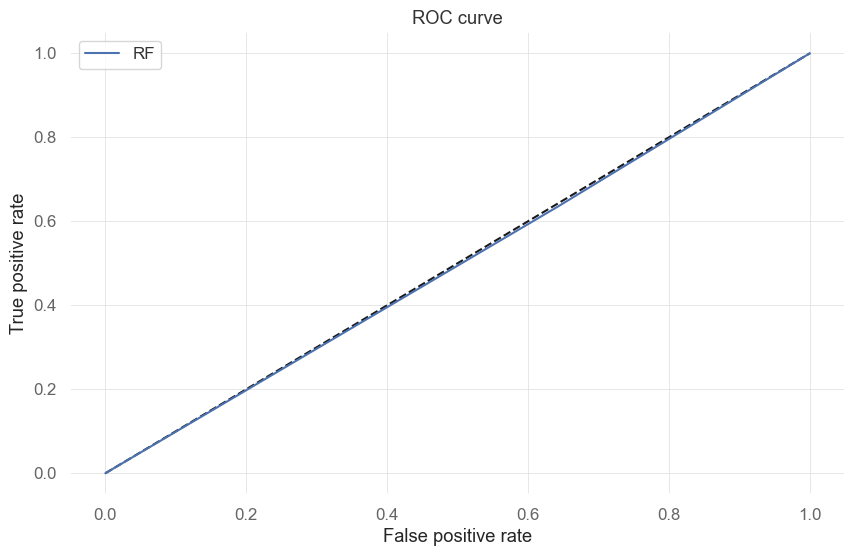

In [129]:

fpr_rf, tpr_rf, _ = roc_curve(testingSetLabels['bin'], rfPredictions)
print(classification_report(testingSetLabels['bin'], rfPredictions))

print("Confusion Matrix")
print(confusion_matrix(testingSetLabels['bin'], rfPredictions))

print('')
print("Accuracy")
print(accuracy_score(testingSetLabels['bin'], rfPredictions))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [130]:
y_train.value_counts()

1.0    950
0.0    802
Name: bin, dtype: int64

In [131]:
789/938

0.8411513859275054

              precision    recall  f1-score   support

         0.0       0.44      0.43      0.43       432
         1.0       0.56      0.57      0.57       558

    accuracy                           0.51       990
   macro avg       0.50      0.50      0.50       990
weighted avg       0.51      0.51      0.51       990

Confusion Matrix
[[186 246]
 [239 319]]

Accuracy
0.51010101010101


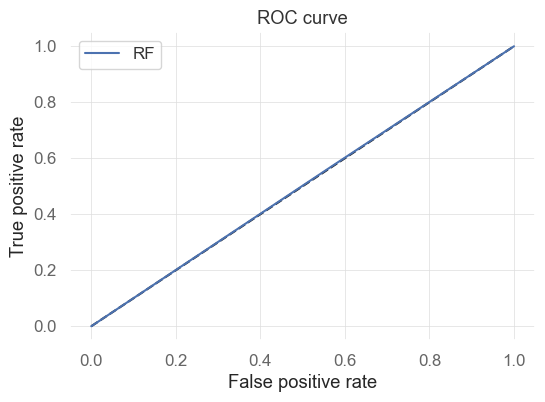

In [132]:

fpr_rf, tpr_rf, _ = roc_curve(testingSetLabels['bin'], svcPredictions)
print(classification_report(testingSetLabels['bin'], svcPredictions))

print("Confusion Matrix")
print(confusion_matrix(testingSetLabels['bin'], svcPredictions))

print('')
print("Accuracy")
print(accuracy_score(testingSetLabels['bin'], svcPredictions))

plt.figure(1, figsize=(6,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [133]:
stepSize = 0.05
numClasses = 10

In [134]:
betSizesRF = betSizing.getSignalNoSide(testingSetEvents,stepSize,rfProbs,rfPredictions,numClasses,numThreads=1)

In [135]:
betSizesSVC = betSizing.getSignalNoSide(testingSetEvents,stepSize,svcProbs,svcPredictions,numClasses,numThreads=1)

# Base model for side

                           Strategy
-------------------------  ----------
Start Period               2021-06-03
End Period                 2024-05-03
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          3.16%
CAGR﹪                     0.74%

Sharpe                     0.26
Prob. Sharpe Ratio         69.42%
Smart Sharpe               0.17
Sortino                    0.36
Smart Sortino              0.24
Sortino/√2                 0.26
Smart Sortino/√2           0.17
Omega                      1.04

Max Drawdown               -5.1%
Longest DD Days            744
Volatility (ann.)          3.3%
Calmar                     0.14
Skew                       -0.02
Kurtosis                   0.28

Expected Daily %           0.0%
Expected Monthly %         0.09%
Expected Yearly %          0.78%
Kelly Criterion            1.89%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.34%
Expected Shortfall (cVaR)  -0.34%

Max Consecutive Wins       7
Max

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-05,2022-10-13,2024-01-18,744,-5.095093,-4.652113
2,2024-04-02,2024-04-19,2024-05-03,32,-0.925360,-0.893877
3,2021-09-20,2021-10-04,2021-10-19,30,-0.842748,-0.811780
4,2021-11-10,2021-12-03,2021-12-07,27,-0.694892,-0.644105
5,2021-12-16,2021-12-20,2021-12-23,8,-0.635848,-0.634418


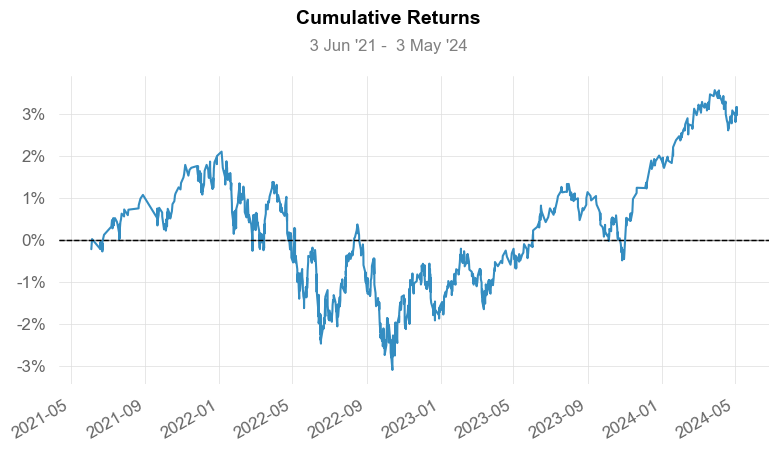

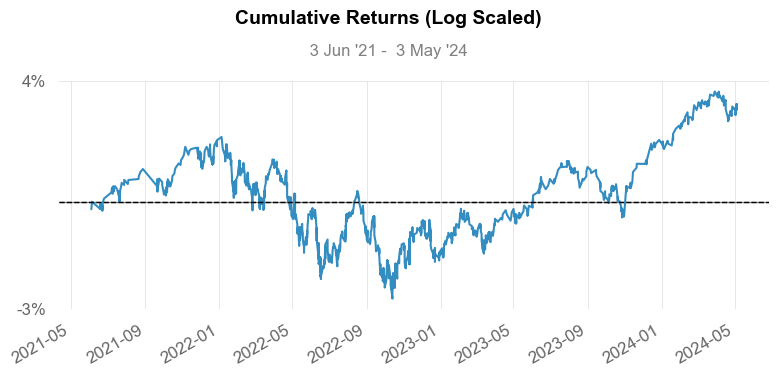

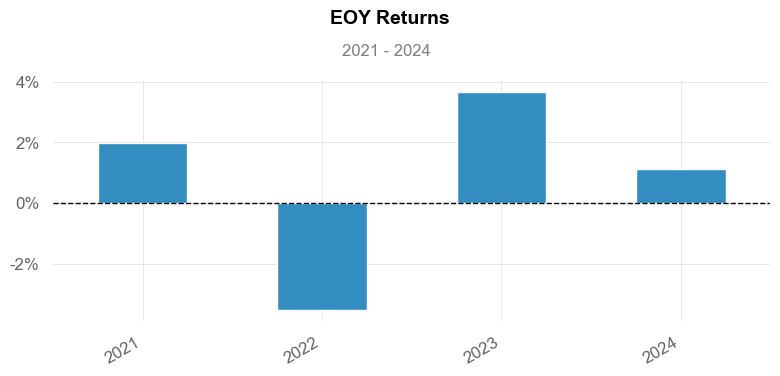

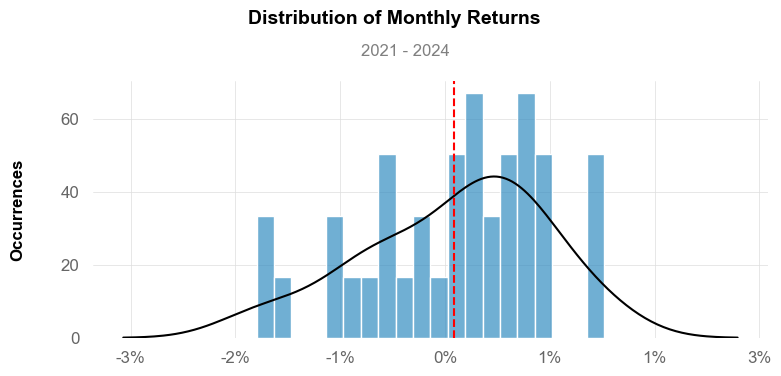

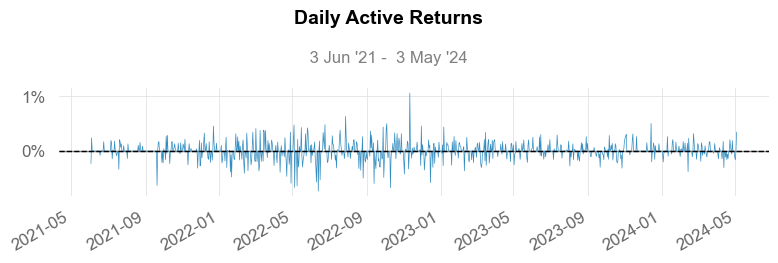

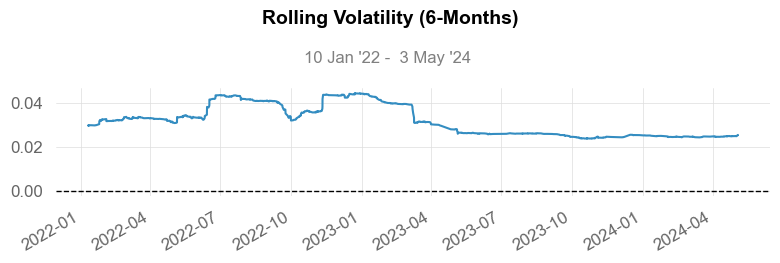

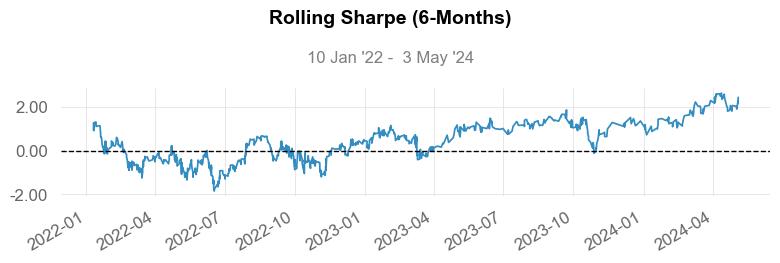

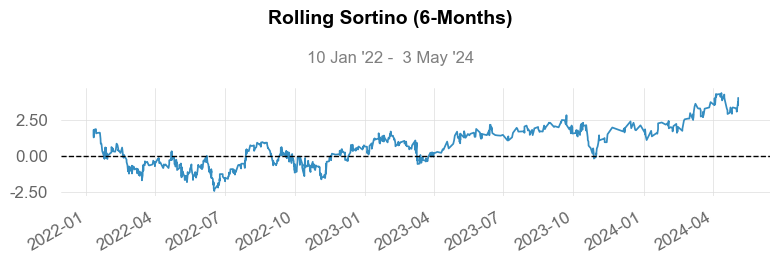

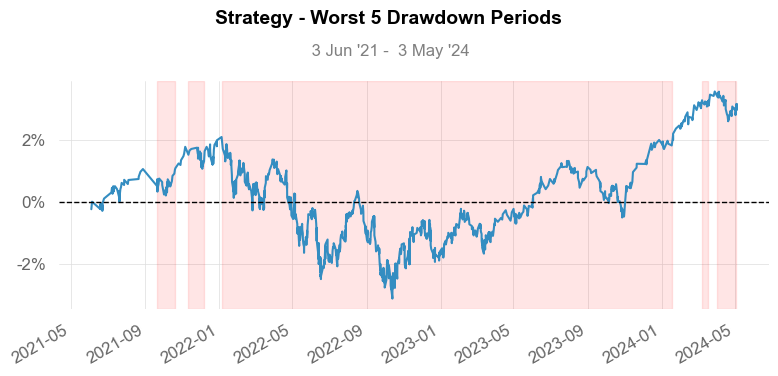

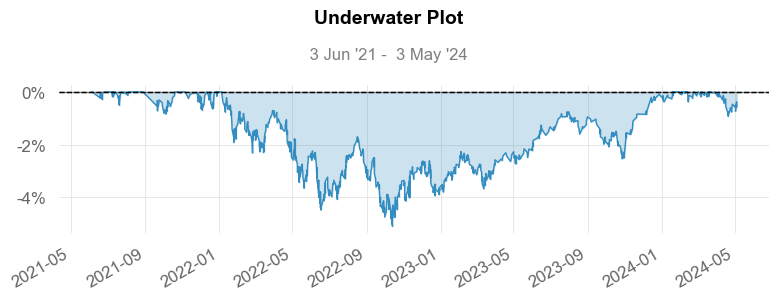

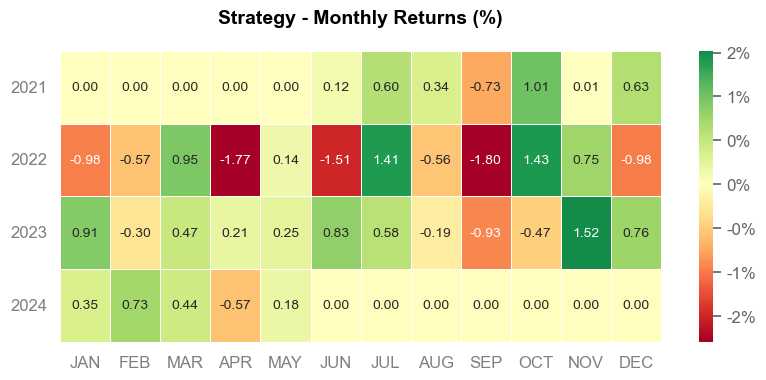

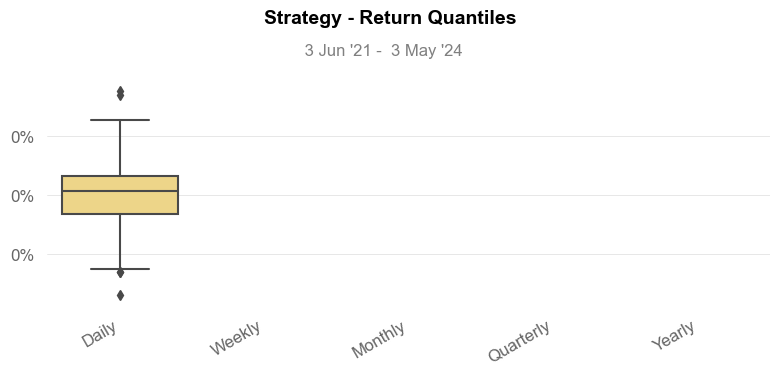

In [136]:
baseRets = np.log(dollarBars.loc[X_test.index]['close']).pct_change()
qs.reports.full(baseRets)

# Triple Barrier labels

                           Strategy
-------------------------  ----------
Start Period               2021-06-01
End Period                 2024-05-03
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          183.31%
CAGR﹪                     27.88%

Sharpe                     1.38
Prob. Sharpe Ratio         99.65%
Smart Sharpe               1.22
Sortino                    2.0
Smart Sortino              1.77
Sortino/√2                 1.41
Smart Sortino/√2           1.25
Omega                      1.25

Max Drawdown               -26.35%
Longest DD Days            360
Volatility (ann.)          20.84%
Calmar                     1.06
Skew                       -0.24
Kurtosis                   0.63

Expected Daily %           0.11%
Expected Monthly %         2.93%
Expected Yearly %          29.74%
Kelly Criterion            11.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.05%
Expected Shortfall (cVaR)  -2.05%

Max Consecutive Wins   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-24,2022-04-22,2022-06-10,138,-26.346536,-23.747386
2,2022-10-28,2022-12-22,2023-10-23,360,-25.626986,-24.513996
3,2022-06-24,2022-07-14,2022-09-26,94,-16.724062,-15.626097
4,2022-09-30,2022-10-13,2022-10-21,21,-15.059007,-14.482312
5,2021-07-19,2021-10-14,2021-12-20,155,-11.546125,-11.355016


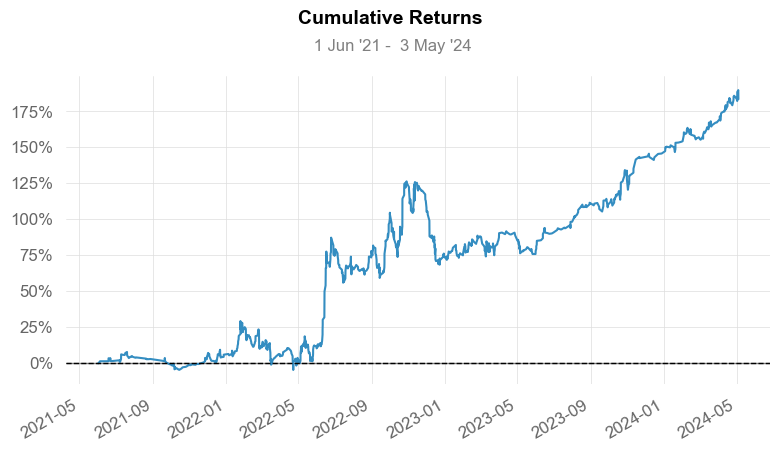

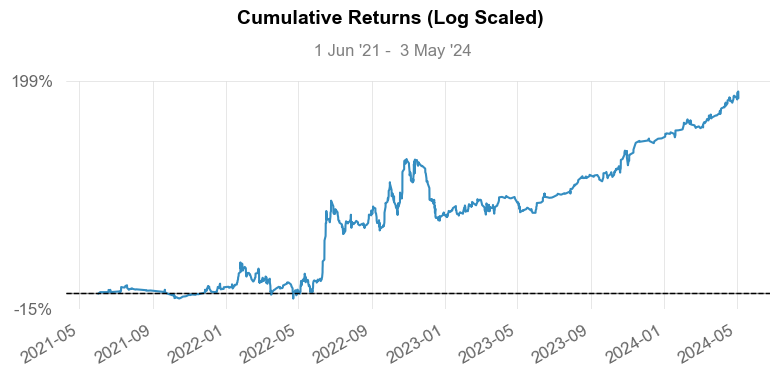

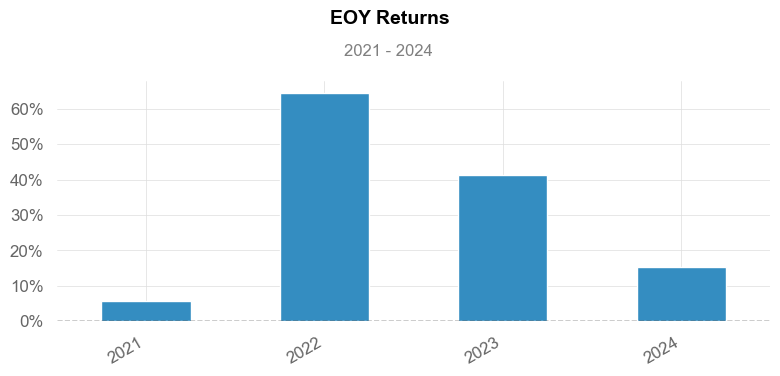

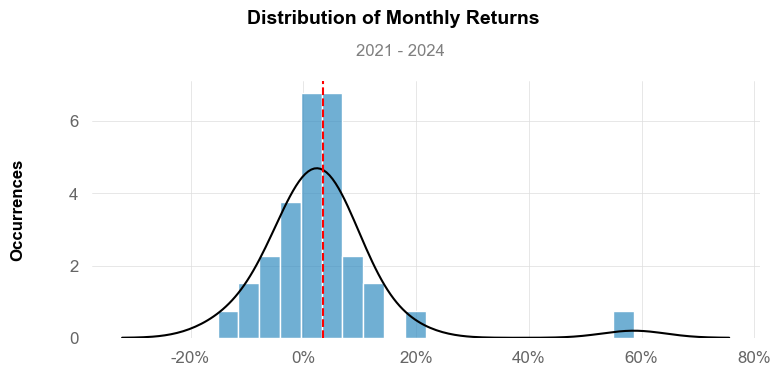

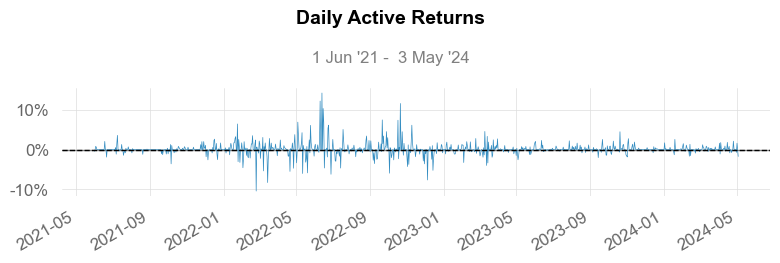

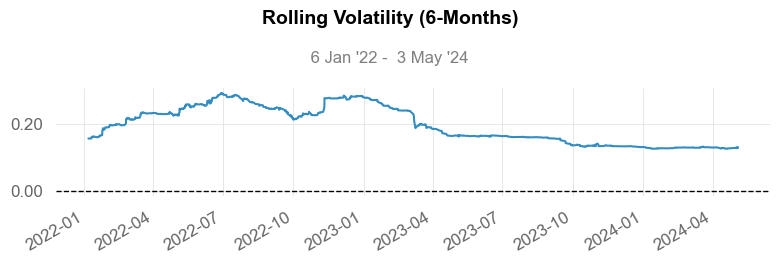

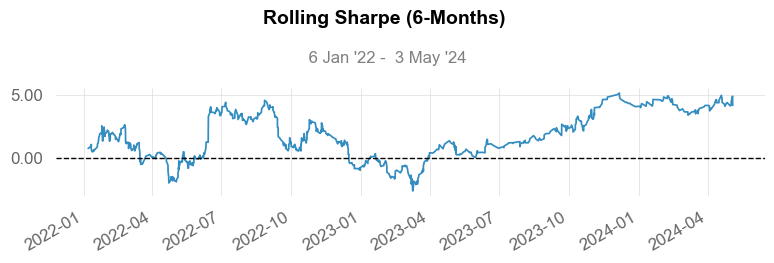

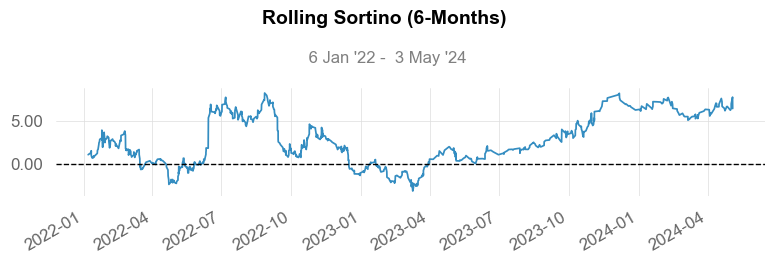

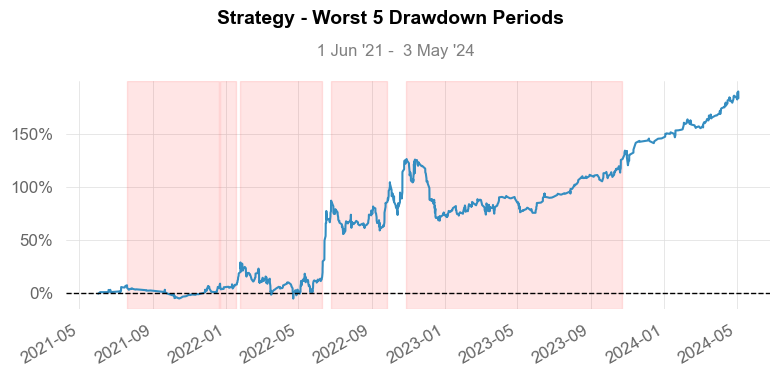

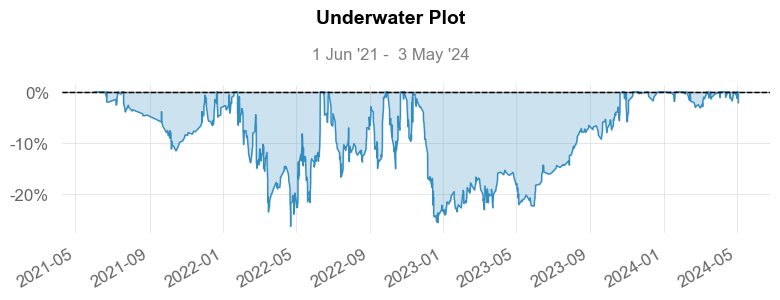

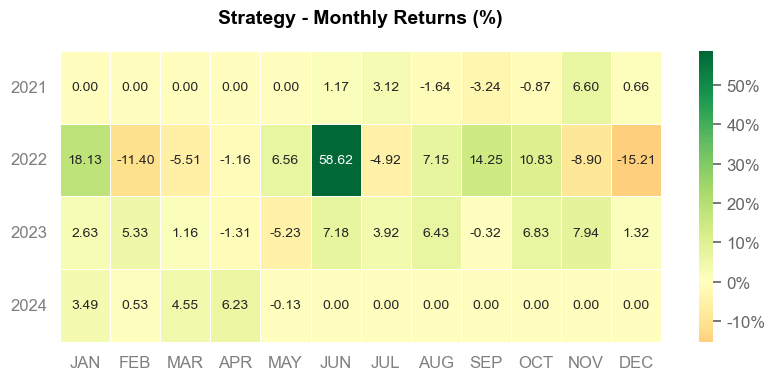

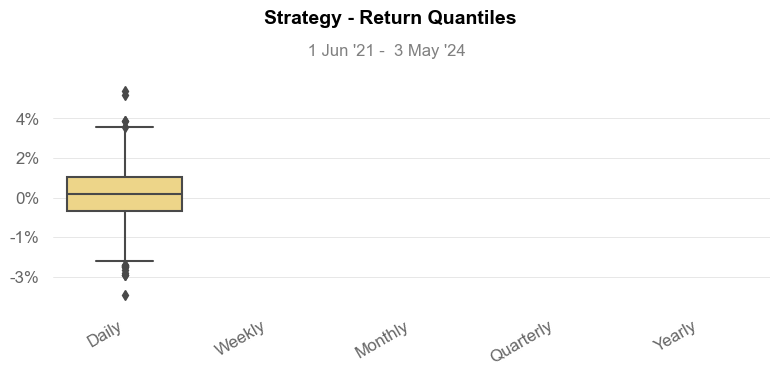

In [137]:
qs.reports.full(testingSetLabels['ret'])

# RFBoot Model

                           Strategy
-------------------------  ----------
Start Period               2021-06-01
End Period                 2024-05-03
Risk-Free Rate             0.0%
Time in Market             81.0%

Cumulative Return          65.79%
CAGR﹪                     12.68%

Sharpe                     1.2
Prob. Sharpe Ratio         99.02%
Smart Sharpe               1.13
Sortino                    1.69
Smart Sortino              1.59
Sortino/√2                 1.2
Smart Sortino/√2           1.12
Omega                      1.25

Max Drawdown               -19.8%
Longest DD Days            459
Volatility (ann.)          11.25%
Calmar                     0.64
Skew                       -0.44
Kurtosis                   4.09

Expected Daily %           0.05%
Expected Monthly %         1.41%
Expected Yearly %          13.47%
Kelly Criterion            11.65%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.11%
Expected Shortfall (cVaR)  -1.11%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-11-01,2022-12-22,2024-02-02,459,-19.796077,-19.451555
2,2022-02-02,2022-05-20,2022-06-13,131,-11.598479,-11.170966
3,2022-06-24,2022-07-15,2022-09-21,89,-9.163877,-7.468871
4,2021-07-19,2021-10-14,2021-11-30,134,-5.694067,-5.622753
5,2022-10-05,2022-10-11,2022-10-13,9,-3.603376,-3.422189


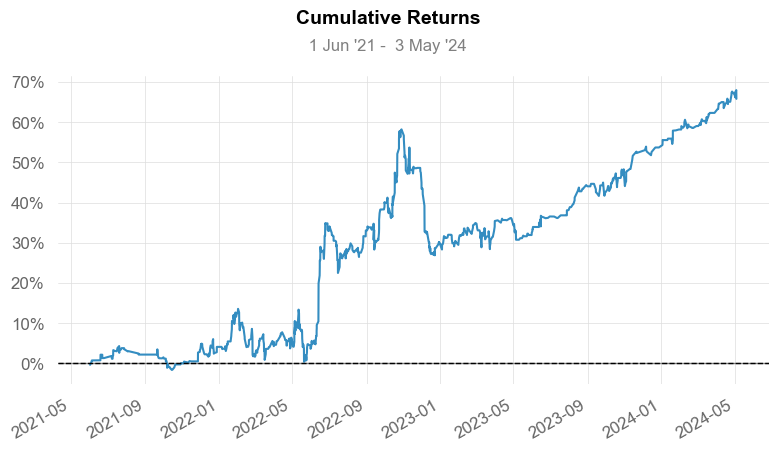

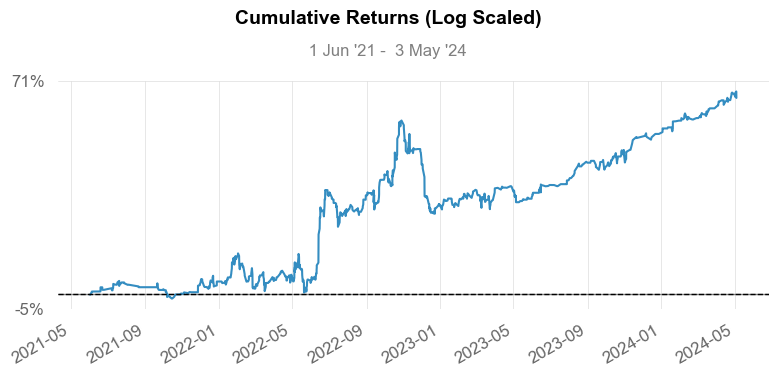

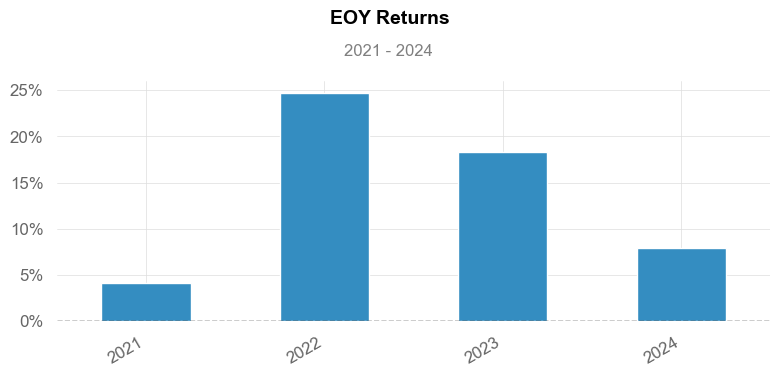

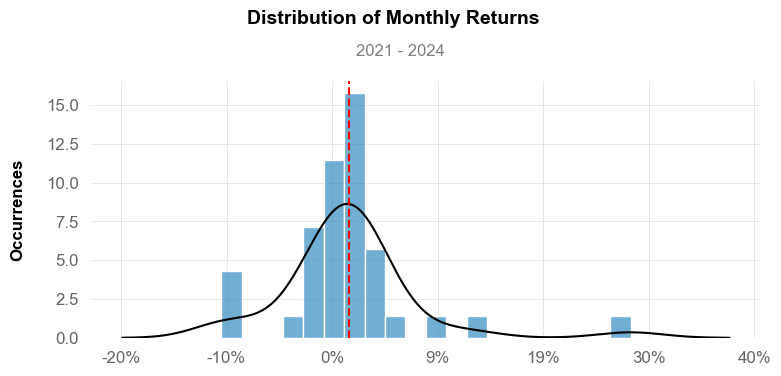

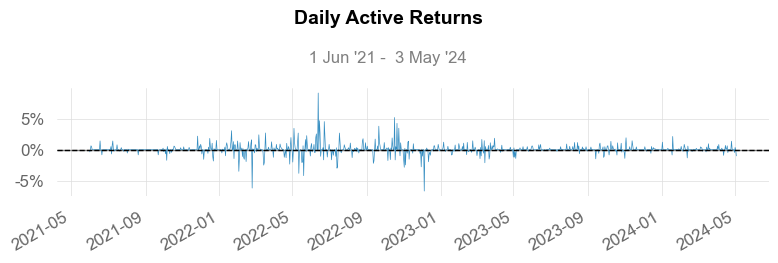

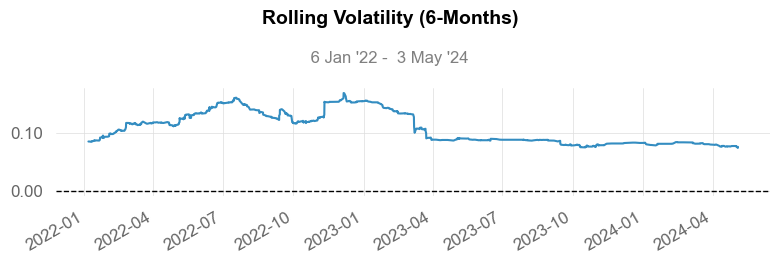

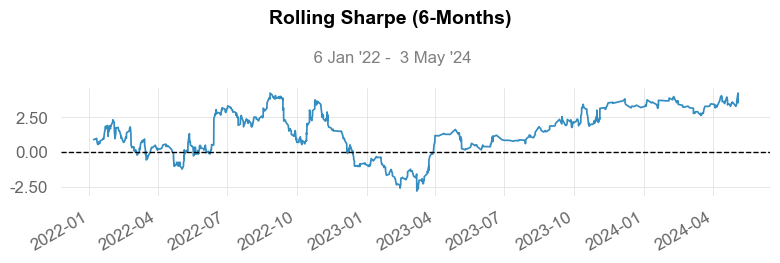

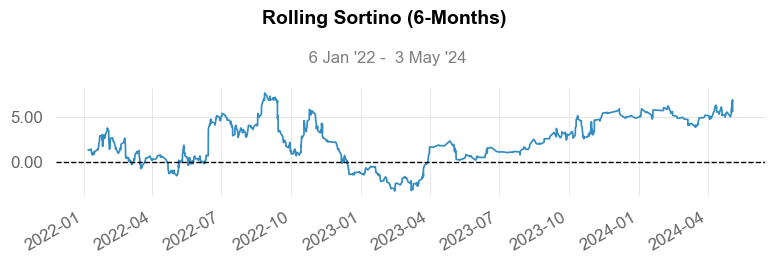

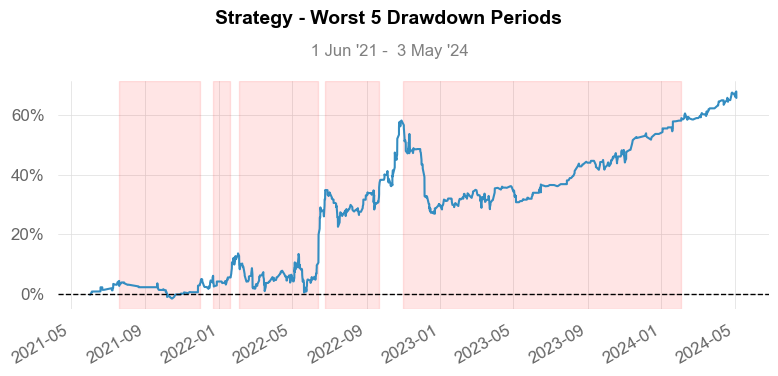

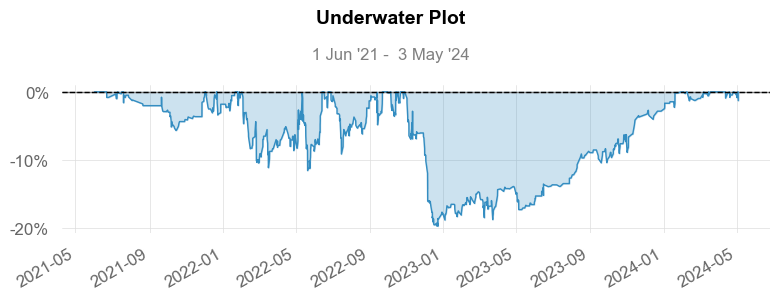

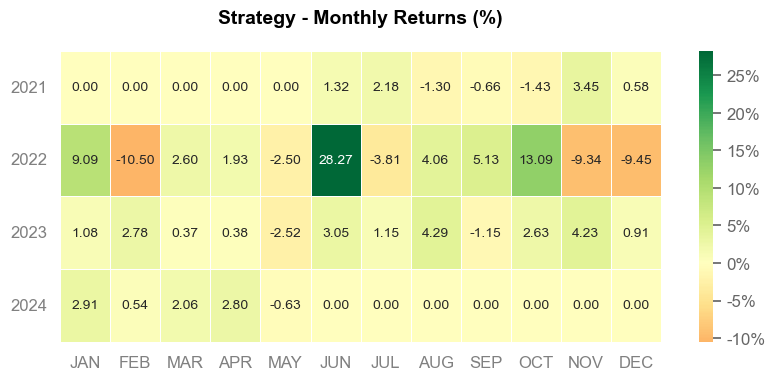

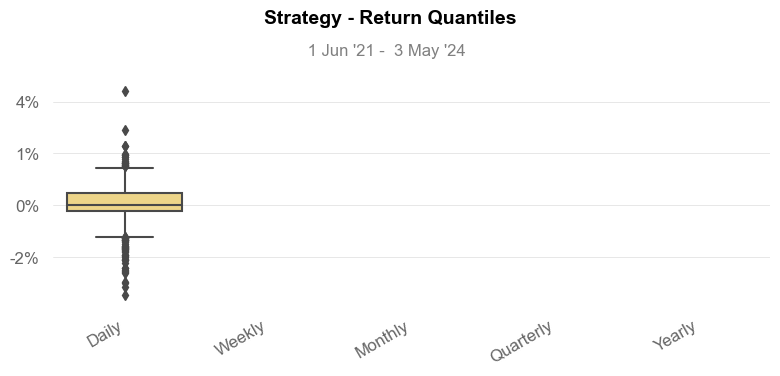

In [138]:
qs.reports.full(betSizesRF * testingSetLabels['ret'])

# SVC Model

                           Strategy
-------------------------  ----------
Start Period               2021-06-01
End Period                 2024-05-03
Risk-Free Rate             0.0%
Time in Market             75.0%

Cumulative Return          47.46%
CAGR﹪                     9.61%

Sharpe                     1.05
Prob. Sharpe Ratio         97.98%
Smart Sharpe               0.96
Sortino                    1.47
Smart Sortino              1.34
Sortino/√2                 1.04
Smart Sortino/√2           0.95
Omega                      1.23

Max Drawdown               -16.21%
Longest DD Days            462
Volatility (ann.)          9.85%
Calmar                     0.59
Skew                       -0.49
Kurtosis                   4.28

Expected Daily %           0.04%
Expected Monthly %         1.08%
Expected Yearly %          10.2%
Kelly Criterion            10.77%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.98%
Expected Shortfall (cVaR)  -0.98%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-10-28,2022-12-22,2024-02-02,462,-16.207479,-15.967050
2,2022-01-27,2022-05-24,2022-06-16,140,-16.185394,-15.809427
3,2022-06-28,2022-07-15,2022-09-22,87,-9.596658,-8.720031
4,2022-10-05,2022-10-13,2022-10-21,16,-4.950528,-4.757846
5,2021-09-20,2021-10-14,2021-11-26,67,-2.758962,-2.622401


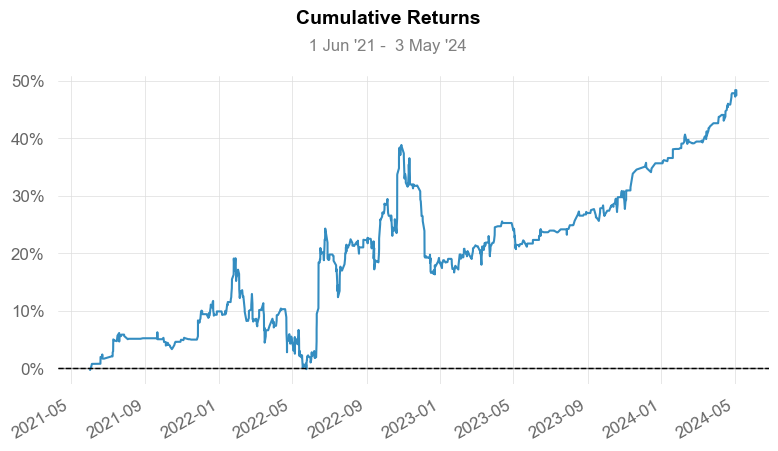

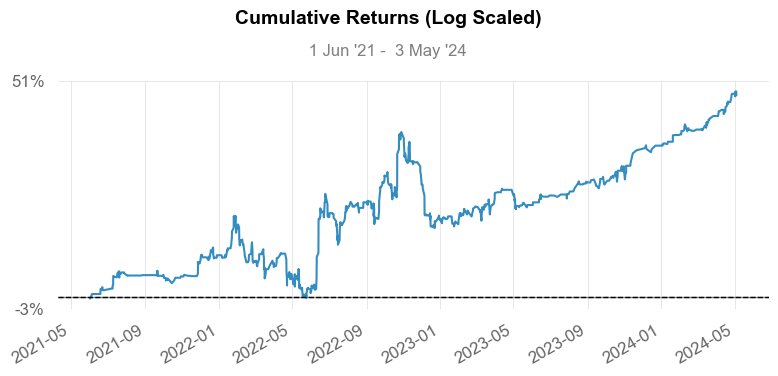

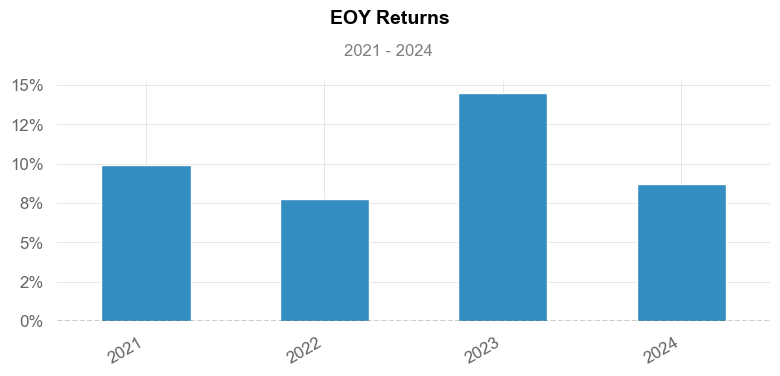

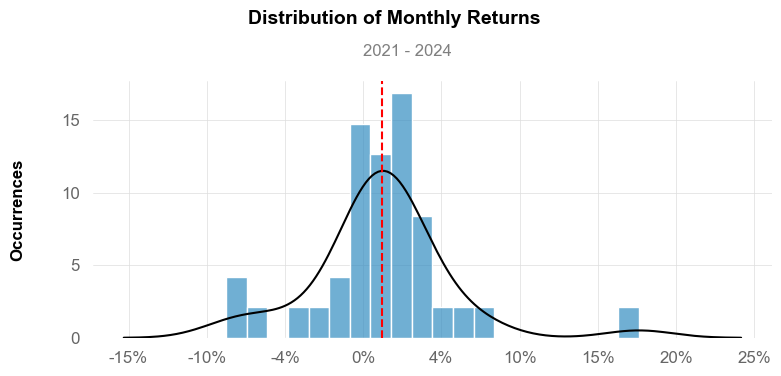

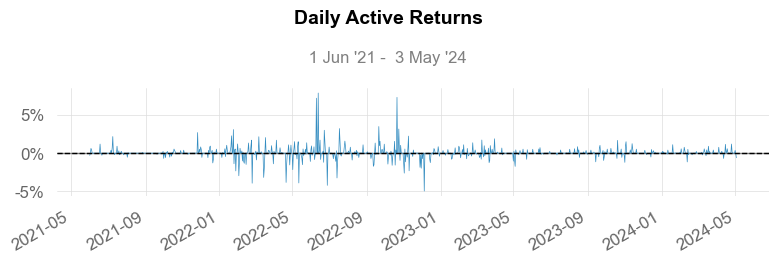

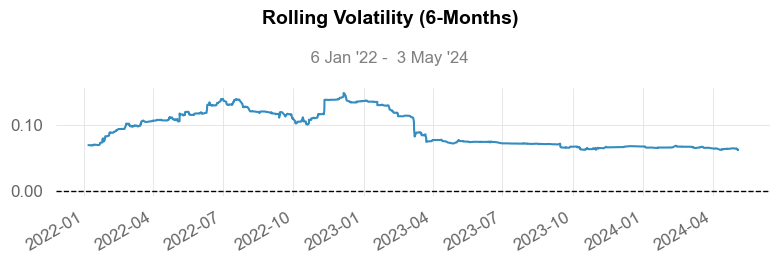

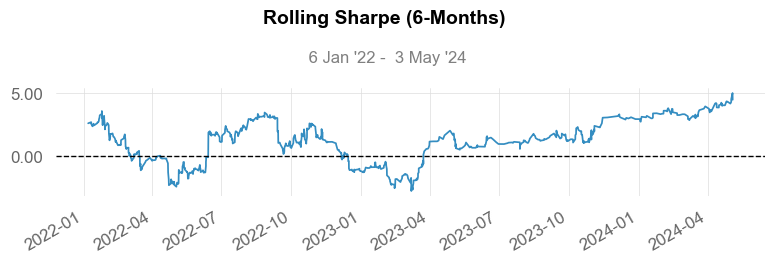

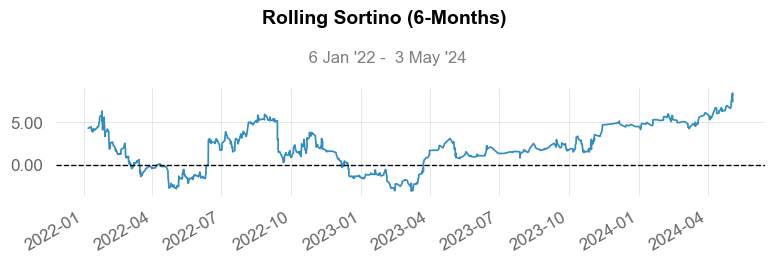

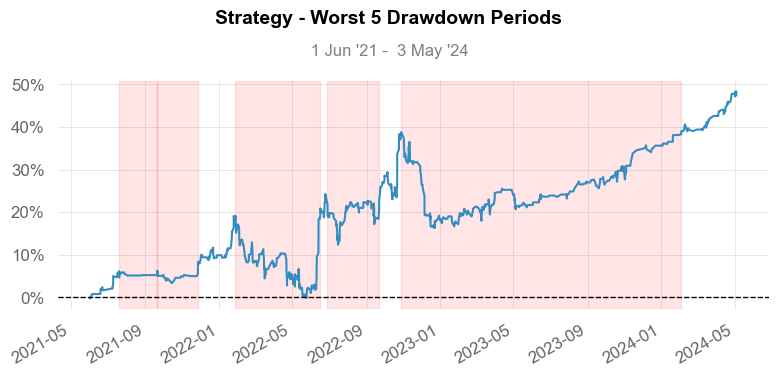

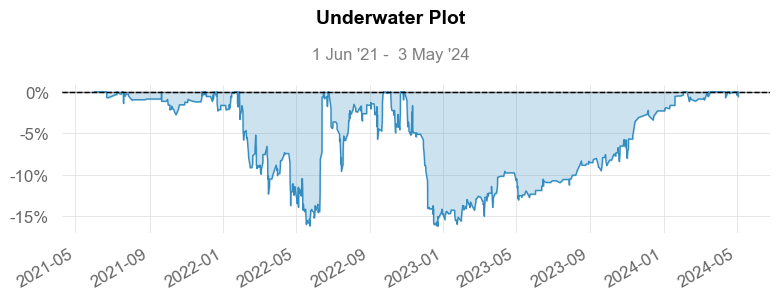

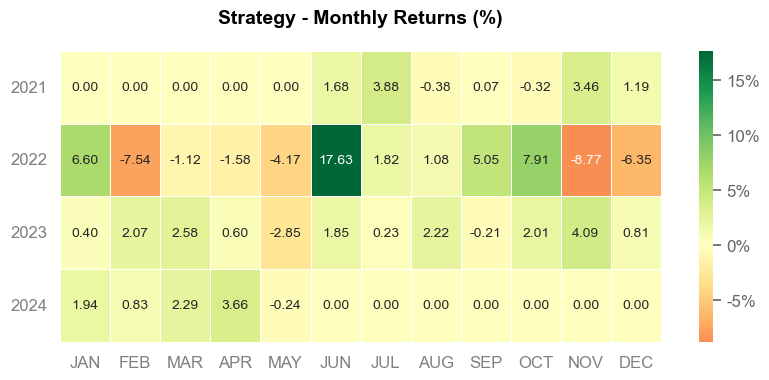

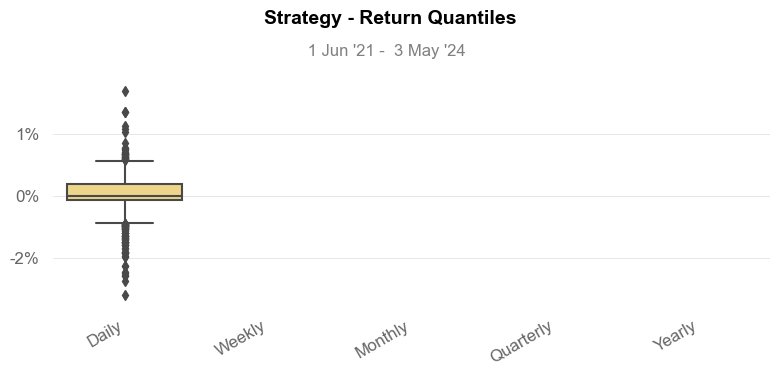

In [139]:
qs.reports.full(betSizesSVC * testingSetLabels['ret'])